In [1]:
import cv2
img = cv2.imread('./Pictures/noisy35/0028.png')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
yuv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)

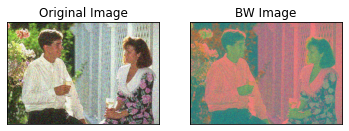

In [2]:
from matplotlib import pyplot as plt

images = []
images.append(rgb_img)
images.append(yuv_img)

titles = ['Original Image','BW Image']

for i in range(len(images)):
    plt.subplot(1,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [3]:
import numpy as np
from PIL import Image
from skimage import img_as_float
import time

def im2patch(im, pch_size, stride=2):
    '''
    Transform image to patches.
    Input:
        im: 3 x H x W or 1 X H x W image, numpy format
        pch_size: (int, int) tuple or integer
        stride: (int, int) tuple or integer
    '''
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size
    else:
        sys.exit('The input of pch_size must be a integer or a int tuple!')

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride
    else:
        sys.exit('The input of stride must be a integer or a int tuple!')


    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = np.zeros((C, pch_H*pch_W, num_pch), dtype=im.dtype)
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

def noise_estimate(im, pch_size=6):
    '''
    Implement of noise level estimation of the following paper:
    Chen G , Zhu F , Heng P A . An Efficient Statistical Method for Image Noise Level Estimation[C]// 2015 IEEE International Conference
    on Computer Vision (ICCV). IEEE Computer Society, 2015.
    Input:
        im: the noise image, H x W x 3 or H x W numpy tensor, range [0,1]
        pch_size: patch_size
    Output:
        noise_level: the estimated noise level
    '''

    if im.ndim == 3:
        im = im.transpose((2, 0, 1))
    else:
        im = np.expand_dims(im, axis=0)

    # image to patch
    pch = im2patch(im, pch_size, 3)  # C x pch_size x pch_size x num_pch tensor
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))  # d x num_pch matrix
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = np.matmul(X, X.transpose()) / num_pch
    sig_value, _ = np.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = np.mean(sig_value[:ii])
        if np.sum(sig_value[:ii]>tau) == np.sum(sig_value[:ii] < tau):
            return np.sqrt(tau)


est_level = noise_estimate(yuv_img[:, :, 0])
sigma = est_level
# sigma = np.round(sigma)

In [4]:
sigma

23.258797557098063

In [5]:
cv2.setUseOptimized(True)
# Parameters initialization
Threshold_Hard3D = 2.7*sigma           # Threshold for Hard Thresholding
if sigma < 40:
    First_Match_threshold = 2500             # Used to calculate the threshold for similarity between blocks
else:
    First_Match_threshold = 5000  
Step1_max_matched_cnt = 16              # The number of blocks for the maximum matching group
Step1_Blk_Size = 8                    # the size of the block，8*8    
Step1_Blk_Step = 2                #use a step of Nstep pixels in both horizontal and vertical directions.                                  
Step1_Search_Step = 2                   # Block search step
Step1_Search_Window = 39                # Search for candidate matching blocks in a local neighborhood of restricted size NS*NS centered
if sigma < 40:
    Second_Match_threshold = 40           # Threshold used to calculate similarity between blocks
else:
    Second_Match_threshold = 350
Step2_max_matched_cnt = 32
Step2_Blk_Size = 6
Step2_Blk_Step = 2
Step2_Search_Step = 2
Step2_Search_Window = 39

Beta_Kaiser = 2.0

In [6]:
import numpy

def init(img, _blk_size, _Beta_Kaiser):
    """该函数用于初始化，返回用于记录过滤后图像以及权重的数组,还有构造凯撒窗"""
    m_shape = img.shape
    #m_img = numpy.matrix(numpy.zeros(m_shape, dtype=float))
    #m_wight = numpy.matrix(numpy.zeros(m_shape, dtype=float))
    m_img = numpy.zeros(m_shape, dtype=float)
    m_wight = numpy.zeros(m_shape, dtype=float)
    K = numpy.matrix(numpy.kaiser(_blk_size, _Beta_Kaiser))
    m_Kaiser = numpy.array(K.T * K)            # 构造一个凯撒窗
    return m_img, m_wight, m_Kaiser


def Locate_blk(i, j, blk_step, block_Size, width, height):
    '''该函数用于保证当前的blk不超出图像范围'''
    if i*blk_step+block_Size < width:
        point_x = i*blk_step
    else:
        point_x = width - block_Size

    if j*blk_step+block_Size < height:
        point_y = j*blk_step
    else:
        point_y = height - block_Size

    m_blockPoint = numpy.array((point_x, point_y), dtype=int)  # 当前参考图像的顶点

    return m_blockPoint


def Define_SearchWindow(_noisyImg, _BlockPoint, _WindowSize, Blk_Size):
    """该函数返回一个二元组（x,y）,用以界定_Search_Window顶点坐标"""
    point_x = _BlockPoint[0]  # 当前坐标
    point_y = _BlockPoint[1]  # 当前坐标

    #print("_noisyImg.shape = "+str(_noisyImg.shape))

    # 获得SearchWindow四个顶点的坐标
    LX = point_x+Blk_Size/2-_WindowSize/2     # 左上x
    LY = point_y+Blk_Size/2-_WindowSize/2     # 左上y
    RX = LX+_WindowSize                       # 右下x
    RY = LY+_WindowSize                       # 右下y

    # 判断一下是否越界
    if LX < 0:   LX = 0
    elif RX > _noisyImg.shape[0]:   LX = _noisyImg.shape[0]-_WindowSize
    if LY < 0:   LY = 0
    elif RY > _noisyImg.shape[1]:   LY = _noisyImg.shape[1]-_WindowSize

    return numpy.array((LX, LY), dtype=int)


def Step1_fast_match_color(_noisyImg, _BlockPoint):
    """快速匹配"""
    '''
    *返回邻域内寻找和当前_block相似度最高的几个block,返回的数组中包含本身
    *_noisyImg:噪声图像
    *_BlockPoint:当前block的坐标及大小
    '''
    (present_x, present_y) = _BlockPoint  # 当前坐标
    Blk_Size = Step1_Blk_Size
    Search_Step = Step1_Search_Step
    Threshold = First_Match_threshold
    max_matched = Step1_max_matched_cnt
    Window_size = Step1_Search_Window
    chnl = _noisyImg.shape[2] # chnl = 3 for color image

    blk_positions = numpy.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
    Final_similar_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size, chnl), dtype=float)
    dct_img = numpy.zeros((Blk_Size, Blk_Size, chnl), dtype=float)
    dct_Tem_img = numpy.zeros((Blk_Size, Blk_Size, chnl), dtype=float)

    for ch in range(chnl):
        img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size, ch]
        dct_img[:,:,ch] = cv2.dct(img.astype(numpy.float64))  # 对目标作block作二维余弦变换

        Final_similar_blocks[0, :, :, ch] = dct_img[:,:,ch]

    blk_positions[0, :] = _BlockPoint

    Window_location = Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
    blk_num = (Window_size-Blk_Size)/Search_Step  # 确定最多可以找到多少相似blk
    blk_num = int(blk_num)
    (present_x, present_y) = Window_location

    similar_blocks = numpy.zeros((blk_num**2, Blk_Size, Blk_Size, chnl), dtype=float)
    m_Blkpositions = numpy.zeros((blk_num**2, 2), dtype=int)
    Distances = numpy.zeros(blk_num**2, dtype=float)  # 记录各个blk与它的相似度


    # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
    matched_cnt = 0
    for i in range(blk_num):
        for j in range(blk_num):
            for ch in range(chnl):
                tem_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size, ch]
                #print("present_x = "+str(present_x)+"; present_y = "+str(present_y)+"; Blk_Size = "+str(Blk_Size))
                #print("tem_img.shape = "+str(tem_img.shape))
                dct_Tem_img[:,:,ch] = cv2.dct(tem_img.astype(numpy.float64))
                #print("dct_img.shape = "+str(dct_img.shape)+"; dct_Tem_img.shape = "+str(dct_Tem_img.shape))
            m_Distance = numpy.linalg.norm((dct_img[:,:,0]-dct_Tem_img[:,:,0]))**2 / (Blk_Size**2) # only on luminance
            #print("step 1 m_Distance : "+str(m_Distance)+ "; Threshold is "+str(Threshold)+"; matched_cnt is "+str(matched_cnt))
            #print("dct_img-dct_Tem_img = "+str(dct_img-dct_Tem_img))
            #print("dct_img = "+str(dct_img))
            #print("dct_Tem_img = "+str(dct_Tem_img))

            # 下面记录数据自动不考虑自身(因为已经记录)
            if m_Distance < Threshold and m_Distance > 0:  # 说明找到了一块符合要求的
                for ch in range(chnl):
                    similar_blocks[matched_cnt, :, :, ch] = dct_Tem_img[:,:,ch]
                m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                Distances[matched_cnt] = m_Distance
                matched_cnt += 1
            present_y += Search_Step
        present_x += Search_Step
        present_y = Window_location[1]
    Distances = Distances[:matched_cnt]
    Sort = Distances.argsort()

    #print("Inside Step1_fast_match(), numpy.sum(numpy.abs(similar_blocks))) = "+str(numpy.sum(numpy.abs(similar_blocks))))

    # 统计一下找到了多少相似的blk
    if matched_cnt < max_matched:
        Count = matched_cnt + 1
    else:
        Count = max_matched

    if Count > 0:
        for i in range(1, Count):
            for ch in range(chnl):
                Final_similar_blocks[i, :, :, ch] = similar_blocks[Sort[i-1], :, :, ch]
            blk_positions[i, :] = m_Blkpositions[Sort[i-1], :]

    return Final_similar_blocks, blk_positions, Count


def Step1_3DFiltering_color(_similar_blocks):
    '''
    *3D变换及滤波处理
    *_similar_blocks:相似的一组block,这里已经是频域的表示
    *要将_similar_blocks第三维依次取出,然在频域用阈值滤波之后,再作反变换
    '''
    chnl = _similar_blocks.shape[3] # chnl = 3 for color image
    statis_nonzero = numpy.zeros(chnl, dtype=int)  # 非零元素个数
    m_Shape = _similar_blocks.shape


    # 下面这一段代码很耗时
    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            for ch in range(chnl):
                tem_Vct_Trans = cv2.dct(_similar_blocks[:, i, j, ch])
                tem_Vct_Trans[numpy.abs(tem_Vct_Trans[:]) < Threshold_Hard3D] = 0.
                statis_nonzero[ch] += tem_Vct_Trans.nonzero()[0].size
                _similar_blocks[:, i, j, ch] = cv2.idct(tem_Vct_Trans)[0]
    return _similar_blocks, statis_nonzero


def Aggregation_hardthreshold_color(_similar_blocks, blk_positions, m_basic_img, m_wight_img, _nonzero_num, Count, Kaiser):
    '''
    *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
    *_similar_blocks:相似的一组block,这里是频域的表示
    *对于最后的数组，乘以凯撒窗之后再输出
    '''
    _shape = _similar_blocks.shape
    chnl = _similar_blocks.shape[3]
    for ch in range(chnl):
        if _nonzero_num[ch] < 1:
            _nonzero_num[ch] = 1
        block_wight = (1./_nonzero_num[ch]) * Kaiser
        for i in range(Count):
            point = blk_positions[i, :]
            tem_img = (1./_nonzero_num[ch])*cv2.idct(_similar_blocks[i, :, :, ch]) * Kaiser
            m_basic_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2], ch] += tem_img
            m_wight_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2], ch] += block_wight


def BM3D_1st_step_color(_noisyImg):
    """第一步,基本去噪"""
    # 初始化一些参数：
    (width, height,chnl) = _noisyImg.shape   # 得到图像的长宽
    block_Size = Step1_Blk_Size         # 块大小
    blk_step = Step1_Blk_Step           # N块步长滑动
    Width_num = (width - block_Size)/blk_step
    Height_num = (height - block_Size)/blk_step
    chnl = _noisyImg.shape[2]

    # 初始化几个数组
    Basic_img, m_Wight, m_Kaiser = init(_noisyImg, Step1_Blk_Size, Beta_Kaiser)

    print("step 1: Width_num = " + str(Width_num) + ", Height_num = " + str(Height_num))

    # 开始逐block的处理,+2是为了避免边缘上不够
    for i in range(int(Width_num+2)):
        print(f'step 1 : {i+1}/{int(Width_num+2)}')
        for j in range(int(Height_num+2)):
            # m_blockPoint当前参考图像的顶点
            m_blockPoint = Locate_blk(i, j, blk_step, block_Size, width, height)       # 该函数用于保证当前的blk不超出图像范围
            Similar_Blks, Positions, Count = Step1_fast_match_color(_noisyImg, m_blockPoint)
            #print("step 1 Similar_Blks shape : "+str(Similar_Blks.shape)+"; Count = "+str(Count)+"; sum(abs(Similar_Blks)) = "+str(numpy.sum(numpy.abs(Similar_Blks))))
            Similar_Blks, statis_nonzero = Step1_3DFiltering_color(Similar_Blks)
            #print("step 1 Similar_Blks shape : "+str(Similar_Blks.shape)+"; step 1 statis_nonzero = "+str(statis_nonzero))
            Aggregation_hardthreshold_color(Similar_Blks, Positions, Basic_img, m_Wight, statis_nonzero, Count, m_Kaiser)
    for ch in range(chnl):
        Basic_img[:, :, ch] /= m_Wight[:, :, ch]
    #basic = numpy.matrix(Basic_img, dtype=int)
    basic = numpy.array(Basic_img, dtype=numpy.int32)
    basic = numpy.clip(basic, 0, 255)
    basic = numpy.array(basic, dtype=numpy.uint8)

    return basic

In [7]:
step1_image = BM3D_1st_step_color(yuv_img)

step 1: Width_num = 156.5, Height_num = 236.5
step 1 : 1/158
step 1 : 2/158
step 1 : 3/158
step 1 : 4/158
step 1 : 5/158
step 1 : 6/158
step 1 : 7/158
step 1 : 8/158
step 1 : 9/158
step 1 : 10/158
step 1 : 11/158
step 1 : 12/158
step 1 : 13/158
step 1 : 14/158
step 1 : 15/158
step 1 : 16/158
step 1 : 17/158
step 1 : 18/158
step 1 : 19/158
step 1 : 20/158
step 1 : 21/158
step 1 : 22/158
step 1 : 23/158
step 1 : 24/158
step 1 : 25/158
step 1 : 26/158
step 1 : 27/158
step 1 : 28/158
step 1 : 29/158
step 1 : 30/158
step 1 : 31/158
step 1 : 32/158
step 1 : 33/158
step 1 : 34/158
step 1 : 35/158
step 1 : 36/158
step 1 : 37/158
step 1 : 38/158
step 1 : 39/158
step 1 : 40/158
step 1 : 41/158
step 1 : 42/158
step 1 : 43/158
step 1 : 44/158
step 1 : 45/158
step 1 : 46/158
step 1 : 47/158
step 1 : 48/158
step 1 : 49/158
step 1 : 50/158
step 1 : 51/158
step 1 : 52/158
step 1 : 53/158
step 1 : 54/158
step 1 : 55/158
step 1 : 56/158
step 1 : 57/158
step 1 : 58/158
step 1 : 59/158
step 1 : 60/158
ste

In [8]:
def Step2_fast_match_color(_Basic_img, _noisyImg, _BlockPoint):
    '''
    *快速匹配算法,返回邻域内寻找和当前_block相似度最高的几个block,要同时返回basicImg和IMG
    *_Basic_img: 基础去噪之后的图像
    *_noisyImg:噪声图像
    *_BlockPoint:当前block的坐标及大小
    '''
    (present_x, present_y) = _BlockPoint  # 当前坐标
    Blk_Size = Step2_Blk_Size
    Threshold = Second_Match_threshold
    Search_Step = Step2_Search_Step
    max_matched = Step2_max_matched_cnt
    Window_size = Step2_Search_Window
    chnl = _noisyImg.shape[2] # chnl = 3 for color image

    blk_positions = numpy.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
    Final_similar_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size, chnl), dtype=float)
    Final_noisy_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size, chnl), dtype=float)
    dct_img = numpy.zeros((Blk_Size, Blk_Size, chnl), dtype=float)
    dct_n_img = numpy.zeros((Blk_Size, Blk_Size, chnl), dtype=float)
    dct_Tem_img = numpy.zeros((Blk_Size, Blk_Size, chnl), dtype=float)

    for ch in range(chnl):
        img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size, ch]
        dct_img[:,:,ch] = cv2.dct(img.astype(numpy.float64))  # 对目标作block作二维余弦变换
        Final_similar_blocks[0, :, :, ch] = dct_img[:,:,ch]

        n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size, ch]
        dct_n_img[:,:,ch] = cv2.dct(n_img.astype(numpy.float64))  # 对目标作block作二维余弦变换
        Final_noisy_blocks[0, :, :,ch] = dct_n_img[:,:,ch]

    blk_positions[0, :] = _BlockPoint

    Window_location = Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
    blk_num = (Window_size-Blk_Size)/Search_Step  # 确定最多可以找到多少相似blk
    blk_num = int(blk_num)
    (present_x, present_y) = Window_location

    similar_blocks = numpy.zeros((blk_num**2, Blk_Size, Blk_Size,chnl), dtype=float)
    m_Blkpositions = numpy.zeros((blk_num**2, 2), dtype=int)
    Distances = numpy.zeros(blk_num**2, dtype=float)  # 记录各个blk与它的相似度

    # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
    matched_cnt = 0
    for i in range(blk_num):
        for j in range(blk_num):
            for ch in range(chnl):
                tem_img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size, ch]
                dct_Tem_img[:,:,ch] = cv2.dct(tem_img.astype(numpy.float64))
            m_Distance = numpy.linalg.norm((dct_img-dct_Tem_img))**2 / (Blk_Size**2)
            #print("dct_img-dct_Tem_img = "+str(dct_img-dct_Tem_img))
            #print("dct_img = "+str(dct_img))
            #print("dct_Tem_img = "+str(dct_Tem_img))

            #print("step 2 m_Distance : "+str(m_Distance)+ "; Threshold is "+str(Threshold)+"; matched_cnt is "+str(matched_cnt))

            # 下面记录数据自动不考虑自身(因为已经记录)
            if m_Distance < Threshold and m_Distance > 0:
                for ch in range(chnl):
                    similar_blocks[matched_cnt, :, :,ch] = dct_Tem_img[:,:,ch]
                m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                Distances[matched_cnt] = m_Distance
                matched_cnt += 1
            present_y += Search_Step
        present_x += Search_Step
        present_y = Window_location[1]
    Distances = Distances[:matched_cnt]
    Sort = Distances.argsort()

    # 统计一下找到了多少相似的blk
    if matched_cnt < max_matched:
        Count = matched_cnt + 1
    else:
        Count = max_matched

    if Count > 0:
        for i in range(1, Count):
            for ch in range(chnl):
                Final_similar_blocks[i, :, :,ch] = similar_blocks[Sort[i-1], :, :,ch]
            blk_positions[i, :] = m_Blkpositions[Sort[i-1], :]

            (present_x, present_y) = m_Blkpositions[Sort[i-1], :]
            for ch in range(chnl):
                n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size, ch]
                Final_noisy_blocks[i, :, :, ch] = cv2.dct(n_img.astype(numpy.float64))

    return Final_similar_blocks, Final_noisy_blocks, blk_positions, Count


def Step2_3DFiltering_color(_Similar_Bscs, _Similar_Imgs, Count):
    '''
    *3D维纳变换的协同滤波
    *_similar_blocks:相似的一组block,这里是频域的表示
    *要将_similar_blocks第三维依次取出,然后作dct,在频域进行维纳滤波之后,再作反变换
    *返回的Wiener_wight用于后面Aggregation
    '''
    chnl = _Similar_Bscs.shape[3] # chnl = 3 for color image
    m_Shape = _Similar_Bscs.shape
    Wiener_wight = numpy.zeros((m_Shape[1], m_Shape[2], m_Shape[3]), dtype=float)

    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            for ch in range(chnl):
                tem_vector = _Similar_Bscs[:, i, j, ch]
                tem_Vct_Trans = numpy.matrix(cv2.dct(tem_vector))
                Norm_2 = numpy.float64(tem_Vct_Trans.T * tem_Vct_Trans)
                m_weight = Norm_2/Count/(Norm_2/Count + sigma_color[ch]**2)
                #print("m_weight = "+str(m_weight))
                if m_weight != 0:
                    Wiener_wight[i, j, ch] = 1./(m_weight**2 * sigma_color[ch]**2)
                else:
                    Wiener_wight[i, j] = 10000
                tem_vector = _Similar_Imgs[:, i, j, ch]
                tem_Vct_Trans = m_weight * cv2.dct(tem_vector)
                _Similar_Bscs[:, i, j, ch] = cv2.idct(tem_Vct_Trans)[0]

    return _Similar_Bscs, Wiener_wight


def Aggregation_Wiener_color(_Similar_Blks, _Wiener_wight, blk_positions, m_basic_img, m_wight_img, Count, Kaiser):
    '''
    *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
    *_similar_blocks:相似的一组block,这里是频域的表示
    *对于最后的数组，乘以凯撒窗之后再输出
    '''
    _shape = _Similar_Blks.shape
    #block_wight = _Wiener_wight # * Kaiser
    chnl = _Similar_Blks.shape[3]

    for ch in range(chnl):
        for i in range(Count):
            point = blk_positions[i, :]
            tem_img = _Wiener_wight[:,:,ch] * cv2.idct(_Similar_Blks[i, :, :, ch]) # * Kaiser
            #tem_img = _Wiener_wight * _Similar_Blks[i, :, :] # * Kaiser
            m_basic_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2],ch] += tem_img
            m_wight_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2],ch] += _Wiener_wight[:,:,ch]


def BM3D_2nd_step_color(_basicImg, _noisyImg):
    '''Step 2. 最终的估计: 利用基本的估计，进行改进了的分组以及协同维纳滤波'''
    # 初始化一些参数：
    (width, height,chnl) = _noisyImg.shape
    block_Size = Step2_Blk_Size
    blk_step = Step2_Blk_Step
    Width_num = (width - block_Size)/blk_step
    Height_num = (height - block_Size)/blk_step

    # 初始化几个数组
    m_img, m_Wight, m_Kaiser = init(_noisyImg, block_Size, Beta_Kaiser)

    print("step 2: Width_num = " + str(Width_num) + ", Height_num = " + str(Height_num))

    for i in range(int(Width_num+2)):
        print(f'step 2 : {i+1}/{int(Width_num+2)}')
        for j in range(int(Height_num+2)):
            m_blockPoint = Locate_blk(i, j, blk_step, block_Size, width, height)
            Similar_Blks, Similar_Imgs, Positions, Count = Step2_fast_match_color(_basicImg, _noisyImg, m_blockPoint)
            #print("step 2 Similar_Blks shape : "+str(Similar_Blks.shape)+"; Count = "+str(Count)+"; sum(abs(Similar_Blks)) = "+str(numpy.sum(numpy.abs(Similar_Blks))))
            Similar_Blks, Wiener_wight = Step2_3DFiltering_color(Similar_Blks, Similar_Imgs, Count)
            #print(Similar_Blks.shape)
            Aggregation_Wiener_color(Similar_Blks, Wiener_wight, Positions, m_img, m_Wight, Count, m_Kaiser)
    for ch in range(chnl):
        m_img[:, :, ch] /= m_Wight[:, :, ch]

    Final = numpy.array(m_img, dtype=numpy.int32)
    Final = numpy.clip(Final, 0, 255)
    Final = numpy.array(Final, dtype=numpy.uint8)

    return Final

In [9]:
sigma_color = [0, 0, 0]
sigma_color[0] = numpy.sqrt(0.299*0.299 + 0.587*0.587 + 0.114*0.144)*sigma
sigma_color[1] = numpy.sqrt(0.169*0.169 + 0.331*0.331 + 0.5*0.5)*sigma
sigma_color[2] = numpy.sqrt(0.5*0.5 + 0.419*0.419 + 0.081*0.081)*sigma

In [10]:
step2_image = BM3D_2nd_step_color(step1_image, yuv_img)

step 2: Width_num = 156.5, Height_num = 236.5
step 2 : 1/158
step 2 : 2/158
step 2 : 3/158
step 2 : 4/158
step 2 : 5/158
step 2 : 6/158
step 2 : 7/158
step 2 : 8/158
step 2 : 9/158
step 2 : 10/158
step 2 : 11/158
step 2 : 12/158
step 2 : 13/158
step 2 : 14/158
step 2 : 15/158
step 2 : 16/158
step 2 : 17/158
step 2 : 18/158
step 2 : 19/158
step 2 : 20/158
step 2 : 21/158
step 2 : 22/158
step 2 : 23/158
step 2 : 24/158
step 2 : 25/158
step 2 : 26/158
step 2 : 27/158
step 2 : 28/158
step 2 : 29/158
step 2 : 30/158
step 2 : 31/158
step 2 : 32/158
step 2 : 33/158
step 2 : 34/158
step 2 : 35/158
step 2 : 36/158
step 2 : 37/158
step 2 : 38/158
step 2 : 39/158
step 2 : 40/158
step 2 : 41/158
step 2 : 42/158
step 2 : 43/158
step 2 : 44/158
step 2 : 45/158
step 2 : 46/158
step 2 : 47/158
step 2 : 48/158
step 2 : 49/158
step 2 : 50/158
step 2 : 51/158
step 2 : 52/158
step 2 : 53/158
step 2 : 54/158
step 2 : 55/158
step 2 : 56/158
step 2 : 57/158
step 2 : 58/158
step 2 : 59/158
step 2 : 60/158
ste

In [11]:
step2_image = cv2.cvtColor(step2_image, cv2.COLOR_YCrCb2RGB)

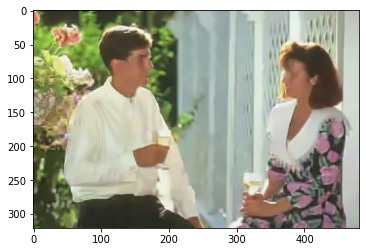

In [12]:
plt.imshow(step2_image)

In [13]:
step2_image = cv2.cvtColor(step2_image, cv2.COLOR_RGB2BGR)

In [14]:
cv2.imwrite("output_image_opencv2.png", step2_image)

True